# Análisis de clientes para Model Fitness.

## Introducción:

En este proyecto, se analizará el comportamiento de los clientes del gimnasio *Model Fitness* con el objetivo de poder identificar a aquellos clientes cuya salida es inminente, es decir, quienes, por sus acciones, podemos predecir dejarán de pagar su membresía al gimnasio. Consideramos que un cliente ya se ha ido o se irá del gimnasio si deja de asistir un mes, ya que, quizá seiguió pagando su mensualidad un mes más, pero lo más seguro es que si ha faltado durante un mes, ya no regresará más y dejará de pagar.

Los resultados que esperamos con este proyecto son:
* Aprender a predecir la probabilidad de pérdida (para el próximo mes) para cada cliente.
* Elaborar retratos de usuarios típicos: selecciona los grupos más destacados y describe sus características principales.
* Analizar los factores que más impactan la pérdida.
* Sacar conclusiones básicas y elaborar recomendaciones para mejorar la atención al cliente:
    * Identificar a los grupos objetivo;
    * Sugerir medidas para reducir la rotación;
    * Describir cualquier otro patrón que observes con respecto a la interacción con los clientes.

## Paso 1: Importación de datos y librerías.

Iniciamos leyendo los datos que se nos han compartido en formta de valores divididos por comas (CSV) e importamos todas las librerías con las que trabajaremos a lo largo del proyecto.

In [40]:
# Importación de las librerías de trabajo.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# Importamos los datos.
df_datos_gym = pd.read_csv("gym_churn_us.csv")

In [3]:
# Presentamos los datos leídos.
df_datos_gym.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Paso 2: Análisis exploratorio de la información.

Similar a lo que hemos trabajado en otros proyectos, iniciaremos analizando la estructura de los datos: ¿cuántas columnas hay? ¿qué tipo de datos tienen? ¿faltan valores? ¿tenemos registros duplicados?

Después, analizaremos los valores des estas columnas para conocer mejor la información recabada y poder plantearnos una hipótesis de trabajo bajo la cual guiar nuestros esfuerzos.

In [4]:
# Revisión de los tipos de datos y valores ausente.
df_datos_gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Con esta información más la previsualización de la tabla que realizamos previamente, podemos obtener algunas observaciones rápidas.
1) No tenemos datos ausentes.
2) Muchas columnas son binarias, es decir 0 ó 1 de dependiendo de la respuesta del usuario, asumimos 1 como SÍ y 0 como NO (para el caso de "gender"/género, 1 = Hombre y 0 = Mujer).
3) Nuestra variable objetivo será "churn" que es si el usuario canceló su plan al siguiente mes de que se obtuvieron estos datos.

Por lo anterior, sabemos también que no hay necesidad de realizar cambios a los datos, así que proseguiremos con el análisis exploratorio.

In [5]:
# Aplicamos el método describe() para obtener datos estadísticos de la tabla.
df_datos_gym.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
Near_Location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
Partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
Promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
Phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
Contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
Group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
Age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
Avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
Month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


Con esta estadística inicial es facil sacar algunas conclusiones de nuestros datos que pudieran llegar a ser relevantes, como por ejemplo:
* La tendencia de las columnas binarias: en un "mundo" aleatorio se esperarían promedios de 0.50, significando que 50% de los clientes han respondido que "Si (1)" y 50% que "No (0)", sin embargo, el qué tan cargado esté hacia el 1 o el 0 dicho promedio, nos da un buen indicativo de la distribución de los valores.
* Podemos ver que toda la clientela es gente joven y que la mayoría son menores de 30 años.
* Podemos ver que todos los clientes han gastado en algo adicional al gimnasio por lo menos en una ocasión.
* Podemos conocer ciertos datos sobre la distribución de las veces que asisten por semana los clientes, ya sea su promedio "global" como el promedio en el mes en curso.

Sobre la última observación, revisando los valores de distribución de datos que nos entrega la función describe(), será casi seguro que, por el nivel de correlación, deberemos descartar a la columna "Avg_class_frequency_current_month" como característica para nuestro modelo predictivo por su alto parecido y correlación con "Avg_class_frequency_total" o viceversa, según  la que resulte con mejores características para ser tomada en cuenta.

### Agrupación según su partida (Churn) del gimnasio.

Ahora agruparemos la tabla según si el cliente dejó o no el gimnasio en el mes siguiente.

In [6]:
# Utilizamos la función groupby para agrupar los datos por la columna "Churn" y obtenemos los promedios.
df_grp_churn = df_datos_gym.groupby("Churn").mean()

In [7]:
# Presentamos los datos agrupados.
df_grp_churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Algunas observaciones preliminares adicionales:
* Hay más personas que viven lejos que dejaron el gimnasio que personas que viven lejos que se quedaron, la distancia puede influir en la decisión.
* Parece que quienes van con un compañero pueden ser menos propensos a dejar el gimnasio.
* Los que contratan menos meses de membresía suelen ser más propensos a dejar el gimnasio.
* Los que dejan el gimnasio suelen consumir menos "adicionales" en promedio.
* Los que dejan el gimnasio van menos veces que los que se quedan.

### Gráficos de distribución.

Para facilitarnos la lectura de los datos, también se presentarán graficos de la distribución de los usuarios.

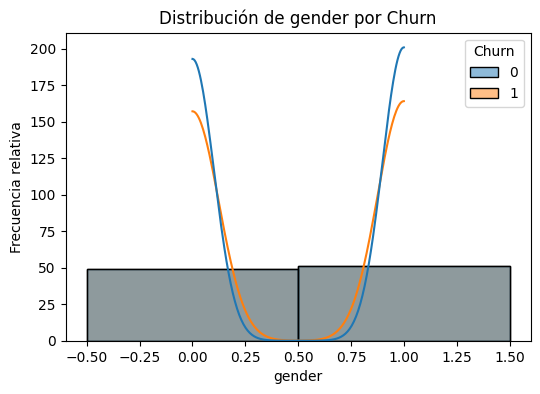

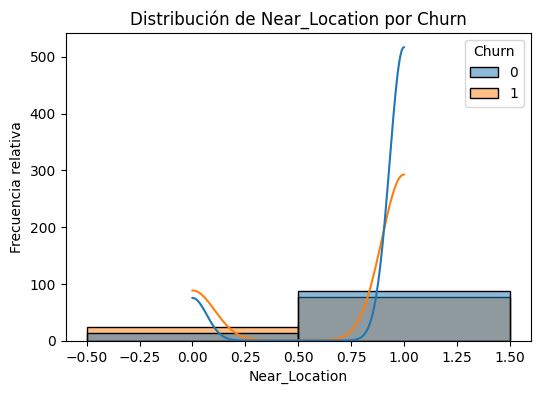

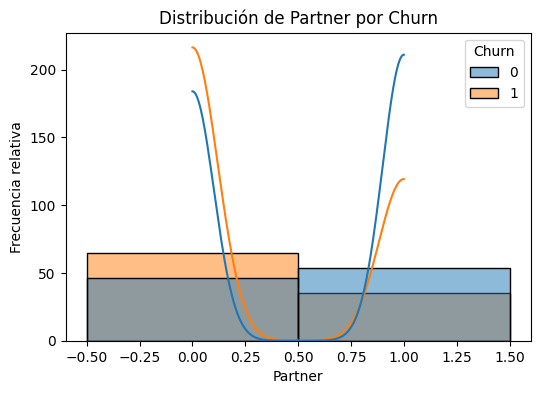

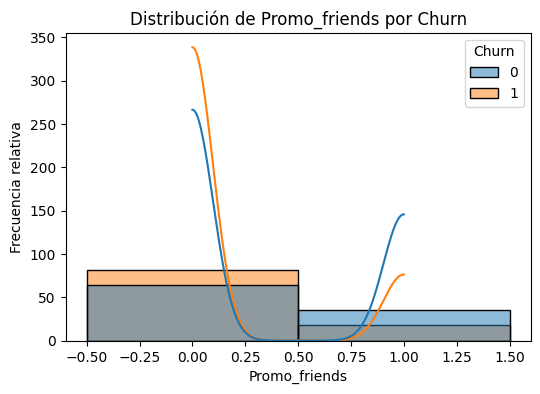

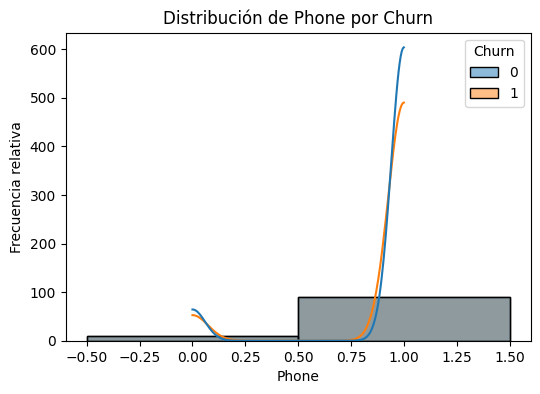

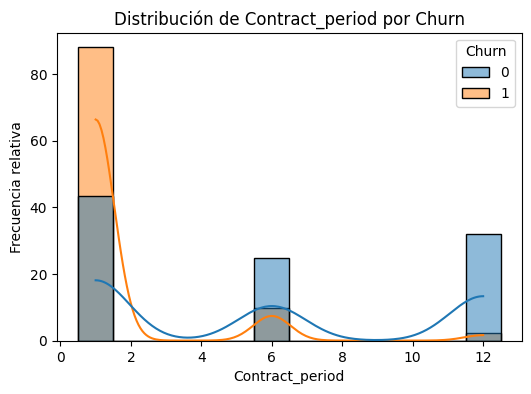

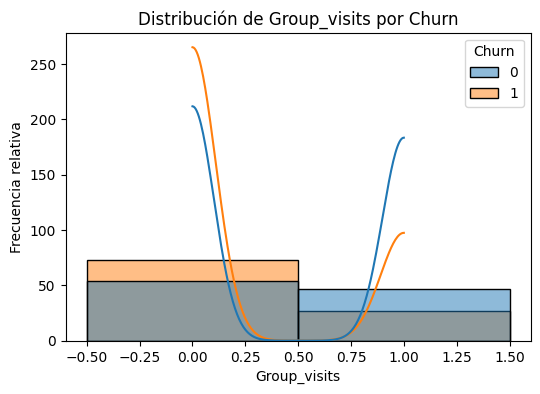

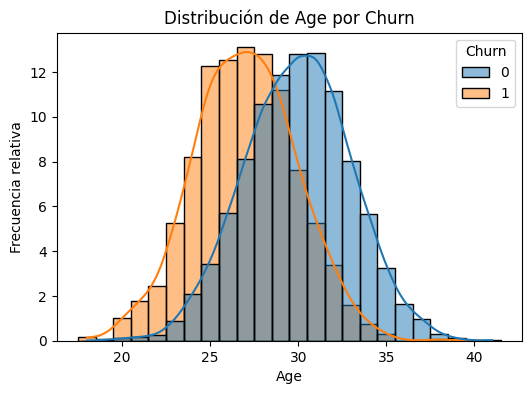

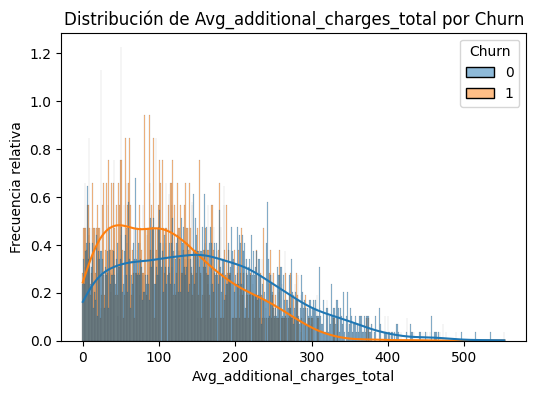

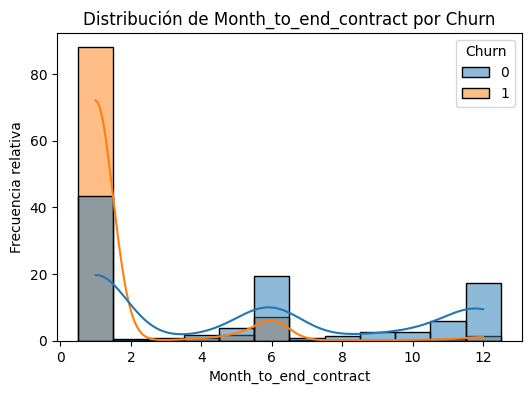

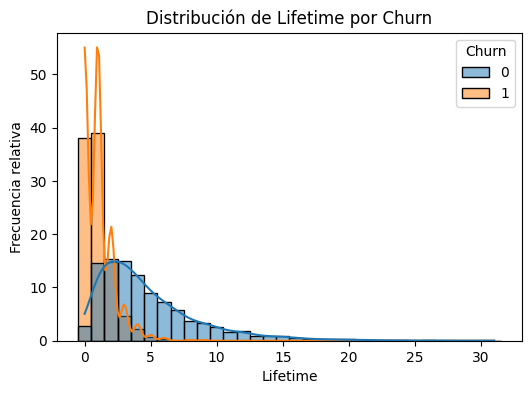

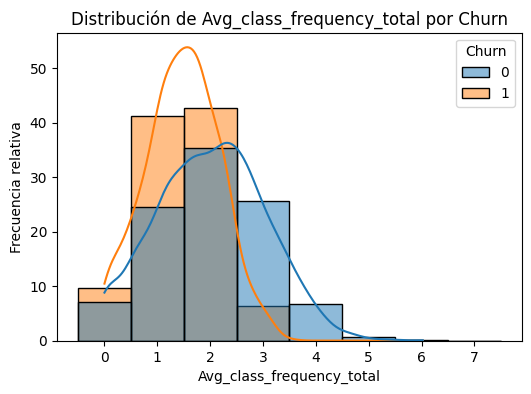

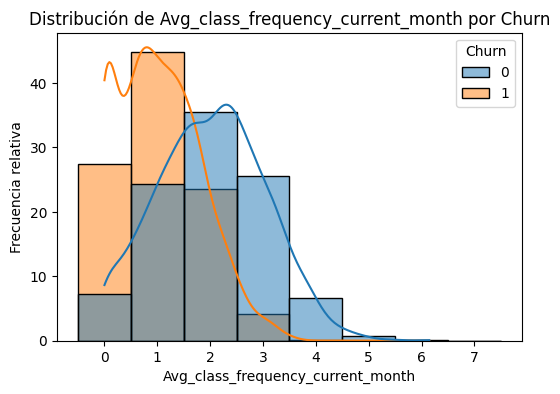

In [8]:
# Ciclamos entre las columnas del df para ir graficando los datos en histogramas de barras que muestren el trazado (kde) y usamos la columna Churn como variable de agrupación (hue).
for col in df_datos_gym.columns:
    if col != "Churn":
        plt.figure(figsize=(6, 4))
        sns.histplot(data=df_datos_gym, x=col, hue="Churn", kde=True,
                     stat="percent", common_norm=False, discrete=True)
        plt.title(f"Distribución de {col} por Churn")
        plt.xlabel(col)
        plt.ylabel("Frecuencia relativa")
        plt.show()

Al graficar los datos, podemos ver que algunas de las observaciones adicionales puede que no sean tan precisas, ahora se puede interpretar un poco mejor la información y vamos dándonos cuenta mejor de como es la clientela de Model Fitness.

### Cálculo de la correlación.

Por último, para cerrar nuestro análisis exploratorio (EDA), calcularemos la correlación que existe entre cada pareja de variables y lo graficaremos con un mapa de calor para visualizar los resultados mejor. Esto no solo nos ayudará a comprender la relación entre cada variable con el hecho de que un cliente deje o no el gimnasio, si no también nos ayudará a ver si hay variables que podamos descartar como características de nuestro modelo de predicción.

In [9]:
# Obtenemo la matrz de correlación con el método corr().
mat_corr = df_datos_gym.corr()

<AxesSubplot: >

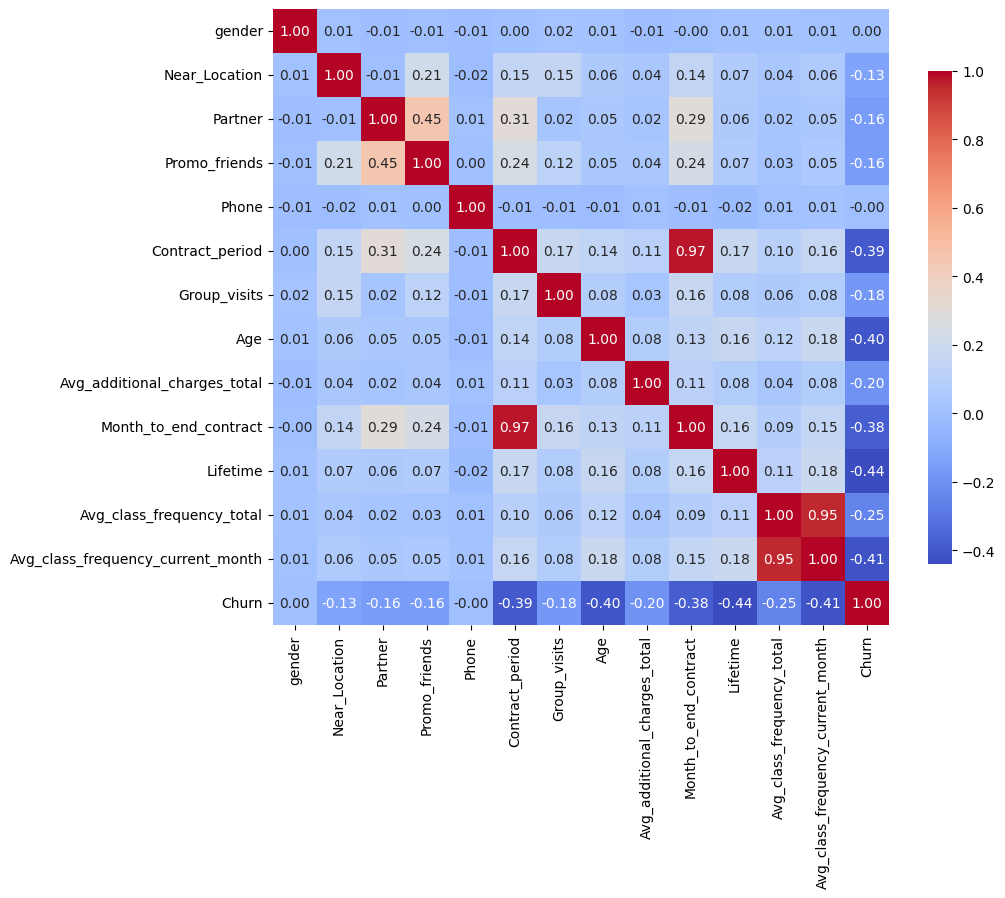

In [10]:
# Graficamos la matrix de correlación con un "heatmap" de Seaborn donde azul será una correlación cercana a 0 y rojo una correlación cercana a +- 1 (valor absoluto de 1).
plt.figure(figsize=(10, 8))
sns.heatmap(mat_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

Como ya habíamos observado antes, el número de sesiones promedio por semana a lo largo del tiempo y en el último mes guardan una fuerte correlación, por lo que no será óptimo mantener ambas características, pero como la duración promedio de los clientes que dejan el gimnasio es menor a 2 meses en promedio, nos quedaremos con la del último mes: "Avg_class_frequency_current_month".

Así mismo, podemos ver que los meses para terminar el "contrato" y la duración del contrato contratado también tienen una correlación entre sí muy fuerte, por lo que lo mejor sería quedarnos únicamente con el periodo del contrato que tiene una correlación ligeramente mayor con "churn".

**Nota: Puesto que en la asignación de este proyecto no se pide recortar el número de columnas / características para fines de perfeccionar el modelo predictivo que se construirá en los siguientes apartados, por lo anterior, no se realizarán cambios al df que contiene los datos recibidos.**

## Construcción del modelo.

El objetivo de este modelo será el obtener la clasificación binaria de los clientes del gimnasio en los grupos: se irá el siguiente mes o no se irá el siguiente mes. Como ya se comentó antes, nuestra variable objetivo es la que ahora está marcada como "churn" y esperamos obtener valores de 0 (no dejará el gimnasio el siguiente mes) y 1 (dejará el gimnasio el siguiente mes).

Utilizaremos el algoritmo "Logistic Regression" de la librería Scikitlearn (sklearn) para construir nuestro modelo de clasificación binaria. Así mismo, para evaluar su desempeño, calcularemos las siguientes métricas:
* Matriz de confusión.
* Exactitud.
* Precisión.
* Recall.
* Puntuación F1.

Posteriormente, utilizaremos el modelo "Random Forest Classifier" de la misma librería. Este algoritmo está diseñado para abordar problemas de clasificación. Calcularemos las mismas métricas y compararemos ambos métodos.

In [11]:
# Establecemos el aleatorizador de las funciones en 0 para fines de obtener siempre los mismos resultados.
rand_state = 0

In [12]:
# Establecemos el modelo de clasificación RamdomForestClassifier.
model_rf = RandomForestClassifier(random_state=rand_state)

In [13]:
# Dividimos los datos en conjuntos de entrenamiento y prueba.
X = df_datos_gym.drop(columns=["Churn"])
y = df_datos_gym["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

### Modelo de regresión logística.

In [14]:
# Establecemos el modelo de clasificación binaria LogisticRegression.
model_log_reg = LogisticRegression(random_state=rand_state, solver="liblinear") # Se elige liblinear al ser la opción binaria en la documentación de sklearn.

In [ ]:
# Entrenamos el modelo de regresión logística.
model_log_reg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [16]:
# Realizamos las predicciones con el modelo utilizando el subconjunto de prueba.
pred_log_reg = model_log_reg.predict(X_test)

#### Matriz de confusión.

In [17]:
# Obtenemos la matriz de confusión.
mat_conf_log_reg = confusion_matrix(y_test, pred_log_reg)
TN, FP, FN, TP = mat_conf_log_reg.ravel()

# Presentamos la matriz de confusión.
print(mat_conf_log_reg)

[[576  26]
 [ 34 164]]


#### Exactitud, Precisión, Recall y F1.

In [34]:
# Cálculo de las métricas de rendimiento del modelo de regresión logística.
ex_log_reg = accuracy_score(y_test, pred_log_reg)
prec_log_reg = precision_score(y_test, pred_log_reg)
rec_log_reg = recall_score(y_test, pred_log_reg)
f1_log_reg = f1_score(y_test, pred_log_reg)

# Presentamos las métricas de rendimiento del modelo de regresión logística.
print(f"Exactitud: {ex_log_reg:.2f}")
print(f"Precisión: {prec_log_reg:.2f}")
print(f"Exhaustividad/Recall: {rec_log_reg:.2f}")
print(f"Puntuación F1: {f1_log_reg:.2f}")

Exactitud: 0.93
Precisión: 0.86
Exhaustividad/Recall: 0.83
Puntuación F1: 0.85


### Modelo de bosque aleatorio.

In [20]:
# Establecemos el modelo de clasificación binaria LogisticRegression.
model_rand_for = RandomForestClassifier(random_state=rand_state)

In [21]:
# Entrenamos el modelo de regresión logística.
model_rand_for.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [22]:
# Realizamos las predicciones con el modelo utilizando el subconjunto de prueba.
pred_rand_for = model_rand_for.predict(X_test)

#### Matrix de confusión.

In [23]:
# Obtenemos la matriz de confusión.
mat_conf_rand_for = confusion_matrix(y_test, pred_rand_for)
TN, FP, FN, TP = mat_conf_rand_for.ravel()

# Presentamos la matriz de confusión.
print(mat_conf_rand_for)

[[571  31]
 [ 36 162]]


#### Exactitud, Precisión, Recall y F1.

In [35]:
# Cálculo de las métricas de rendimiento del modelo de regresión logística.
ex_rand_for = accuracy_score(y_test, pred_rand_for)
prec_rand_for = precision_score(y_test, pred_rand_for)
rec_rand_for = recall_score(y_test, pred_rand_for)
f1_rand_for = f1_score(y_test, pred_rand_for)

# Presentamos las métricas de rendimiento del modelo de regresión logística.
print(f"Exactitud: {ex_rand_for:.2f}")
print(f"Precisión: {prec_rand_for:.2f}")
print(f"Exhaustividad/Recall: {rec_rand_for:.2f}")
print(f"Puntuación F1: {f1_rand_for:.2f}")

Exactitud: 0.92
Precisión: 0.84
Exhaustividad/Recall: 0.82
Puntuación F1: 0.83


### Comparación de los modelos.

Ambos modelos obtuvieron resultados bastante similares en cuanto a su matriz de confusión y, por ende, a las métricas con las que trabajamos que, aunque utilizamos funciones preconstruidas, se pueden obtener mediante los valores de la matriz de confusión. Sin embargo, el modelo de Regresión Lineal resultó obtener valores ligéramente superiores.

Esto pudiese ser atribuible al hecho de que la versión de "solucionador" usado (liblinear) ha sido construida específicamente para abordar problemas de clasificaicón binaria, mientras que el clasificador por bosque aleatorio es un algoritmo de clasificación más generalista.

## Clasificación de los usuarios (agrupación).

En esta sección constuiremos un modelo que nos permita agrupar a los usuarios de acuerdo con sus características. Primero se estandarizarán los datos de las características para poder obtener distribuciones más cercanas a una distribución normal; después obtendremos el dendograma de las características que nos permitirá seleccionar un número de grupos entre los cuales dividir a los clientes, por último, aplicaremos el algoritmo Kmeans para agrupar a los clientes. 

In [36]:
# Iniciamos estandarizando los datos de las características (X).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
# Usamos la función linkage para crear una matriz de distancias jerárquicas.
linked = linkage(X_scaled, method = 'ward')

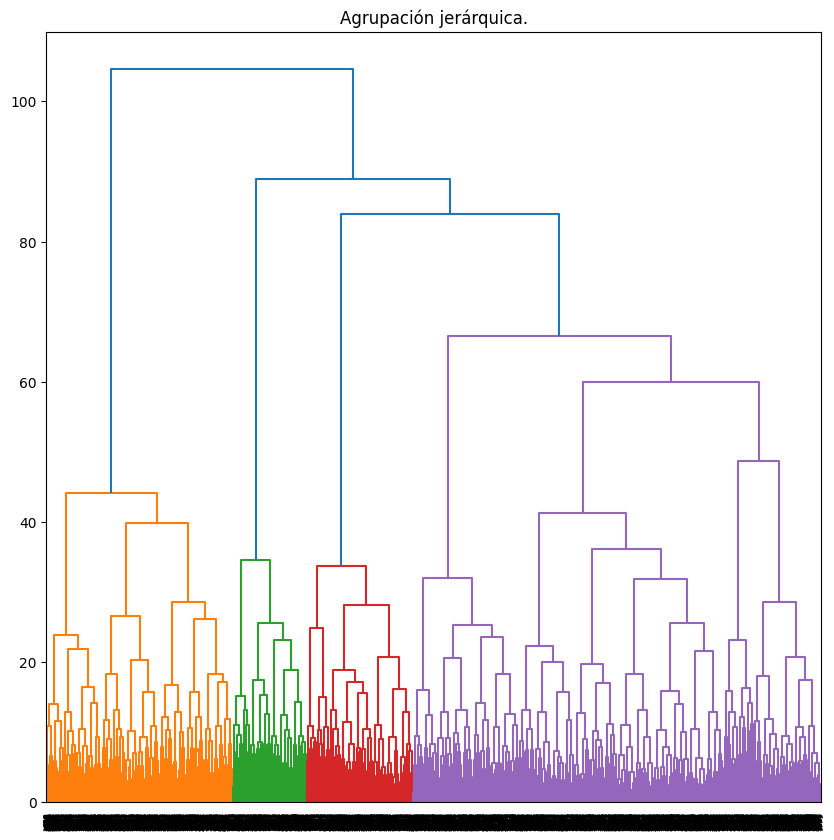

In [39]:
# Graficamos el dendrograma.
plt.figure(figsize=(10,10))
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica.')
plt.show()

De acuerdo con el gráfico anterior, el número óptimo de conjuntos de clientes sería 4 (naranja, verde, rojo y morado).

**Nota: la asignación solicita que se utilice el método K-means con n=5, es decir, que obtengamos 5 conjuntos, por lo que se seguirá dicho proceso.**

### Construcción del modelo.

In [41]:
# Establecemos el modelo de agrupación K-means.
mod_kmeans = KMeans(n_clusters=5)

# Creamos las etiquetas de los grupos.
etiquetas = mod_kmeans.fit_predict(X_scaled)

In [42]:
# Agregamos las etiquetas al DataFrame original.
df_datos_gym['Cluster'] = etiquetas

### Revisión de los conjuntos.

Ahora que hemos etiquetado a cada cliente de acuerdo con los resultados de nuestro modelo de agrupación, revisaremos los valores promedio para cada columna por grupo.

In [43]:
# Agrupamos los datos por el Cluster (conjunto) y calculamos los valores medios de cada columna.
df_grp_cluster = df_datos_gym.groupby('Cluster').mean()

# Presentamos los datos.
df_grp_cluster

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster,,,,,,,,,,,,,,
0,0.501068,0.944444,0.741453,0.489316,0.900641,11.878205,0.552350,29.913462,164.843651,10.869658,4.705128,1.991983,1.983475,0.022436
1,0.484099,1.000000,0.243816,0.010601,0.902827,1.976148,0.322438,28.227032,131.524179,1.893993,2.454064,1.306977,1.071938,0.516784
2,0.593085,0.972074,0.281915,0.117021,0.894947,2.909574,0.484043,30.319149,162.953822,2.666223,5.180851,2.924785,2.929752,0.057181
3,0.485804,1.000000,0.805994,1.000000,0.908517,3.102524,0.451104,29.078864,140.097349,2.881703,3.610410,1.682177,1.565955,0.263407
4,0.494505,0.000000,0.465201,0.076923,0.915751,2.225275,0.214286,28.478022,134.126172,2.089744,2.805861,1.659607,1.469327,0.448718


Algunas observaciones:
* Sexo: en general los grupos de clientes están homogéneos en cuanto a su género, excepto por el grupo 2 que tiene más hombres que mujeres.
* Cercanía: El grupo 4 está compuesto por puros clientes que viven lejos del gimnasio.
* Compañero: Los grupos 0 y 3 tienen clientes que asisten predominantemente con un compañero.
* Promo amigos: Los grupos 0 y 3 son aquellos que más aprovecharon la promoción de amigos, todos los miembros del grupo 3 la aprovecharon.
* Duración del contrato: el grupo 0 está compuesto por una mayoría de clientes que contrató todo el año (12 meses).
* Sesiones de grupo: los usuarios del grupo 0 son quienes más participan en sesiones grupales, sin embargo, los grupos 2 y 3 también cuentan con participaciones grupales cerca del 50%.
* Consumos adicionales: los usuarios de los grupos 0 y 2 son quines más gastos adicionales a su mensualidad registran.
* Meses para terminar su contrato: el grupo 0 está compuesto por muchos usuarios que contrataron por 12 meses pero que apenas llevan un par. El grupo 1 tiene más usuarios que están próximos a que venza su contrato.
* Tiempo inscritos: Los usuarios del grupo 2 son los que llevan más tiempo inscritos en promedio, seguido por los del grupo 0.
* Cantidad promedio de clases a la semana (global): Los usuarios del grupo 2 son los que más veces asisten en promedio, seguido por los del grupo 0.
* Cantidad promedio de clases a la semana (mes corriente): Los usuarios del grupo 2 son los que más veces asisten en promedio, seguido por los del grupo 0.
* Churn: Los grupos con usuarios menos propensos a dejar el gimnasio en el siguiente mes son el 0 y el 2. El grupo más propenso a dejar el gimnasio es el 1.

Graficaremos las distribuciones de cada variable para visualizar mejor los datos.

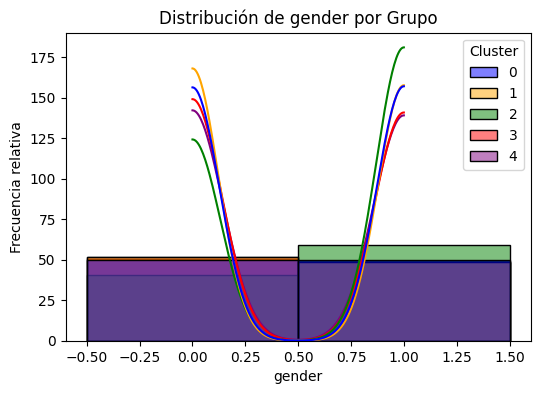

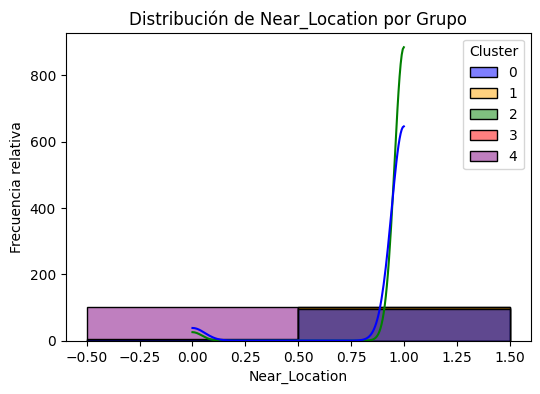

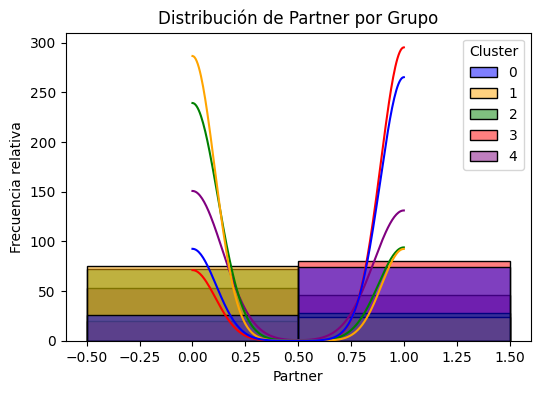

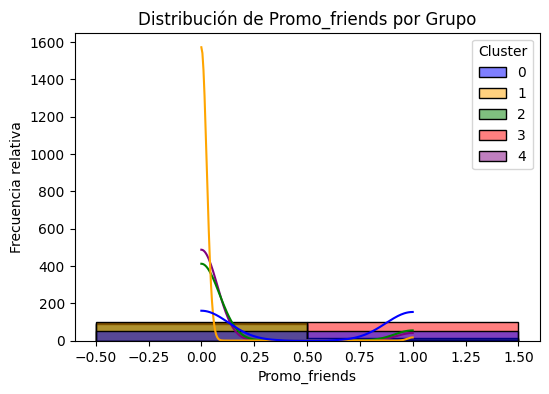

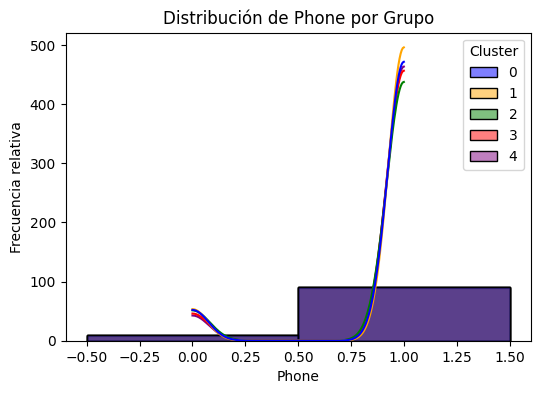

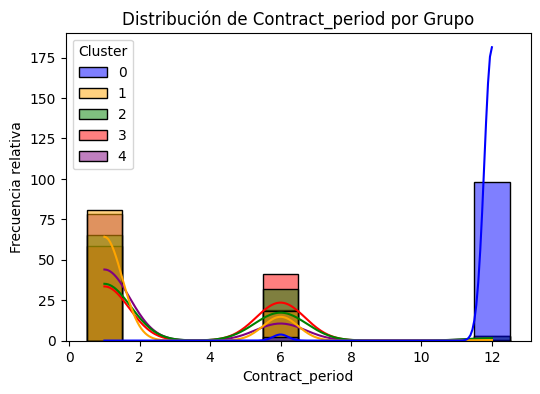

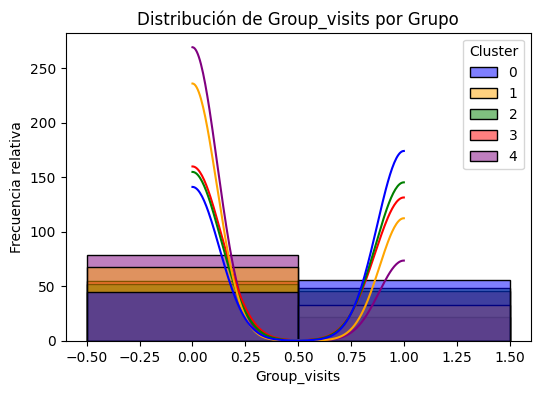

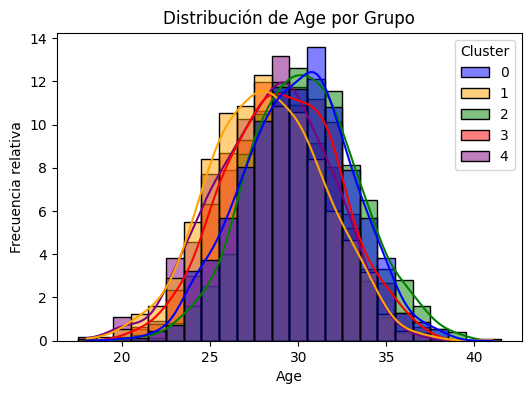

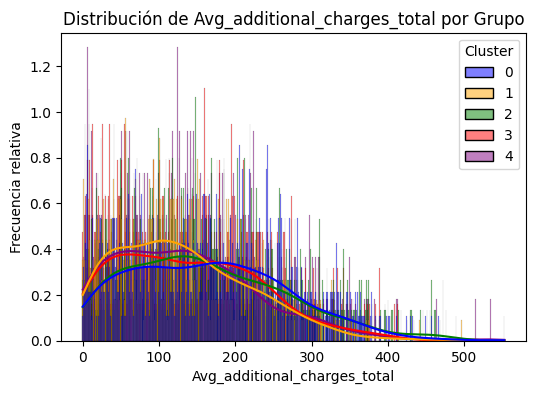

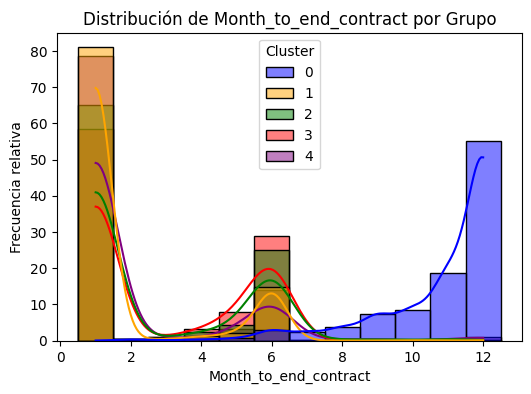

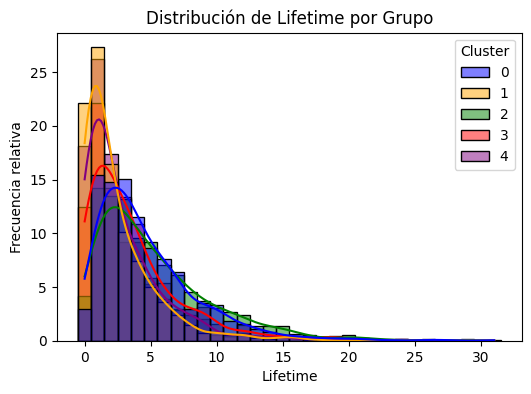

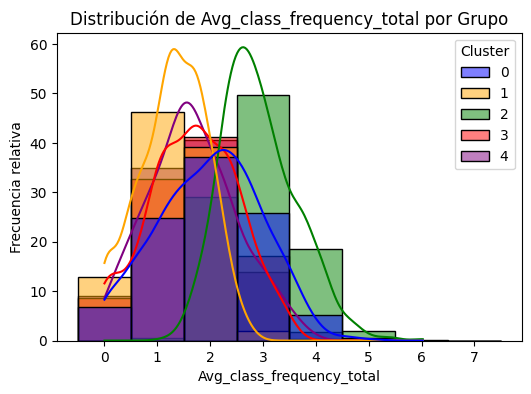

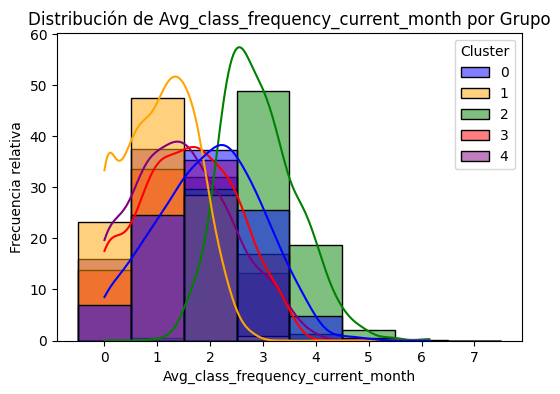

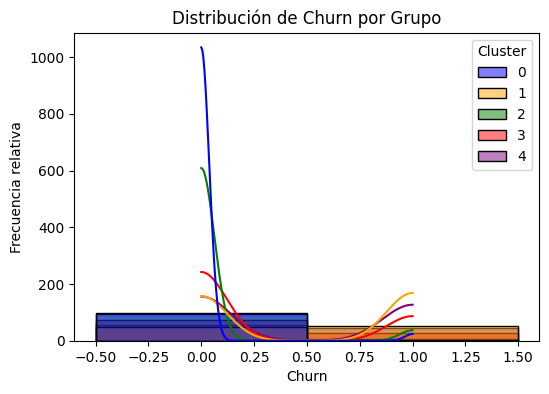

In [45]:
# Ciclamos entre las columnas del df para ir graficando los datos en histogramas de barras que muestren el trazado (kde) y usamos la columna Cluster como variable de agrupación (hue).
for col in df_datos_gym.columns:
    if col != "Cluster":
        plt.figure(figsize=(6, 4))
        sns.histplot(data=df_datos_gym, x=col, hue="Cluster", kde=True,
                     stat="percent", common_norm=False, discrete=True,
                     palette=["Blue","Orange","Green","Red","Purple"])
        plt.title(f"Distribución de {col} por Grupo")
        plt.xlabel(col)
        plt.ylabel("Frecuencia relativa")
        plt.show()

En general podemos ver algunas coincidencias entre los grupos 0 y 2, que cuentan con los clientes menos propensos a dejar el gimnasio el siguiente mes:
* Tienen una edad promedio ligeramente superior.
* En promedio, realizan gastos mayores adicionales a la membresía.
* Asisten a más clases por semana.
* Tienen los promedios más altos de tiempo inscritos.

Estos grupos tienen marcadas diferencias que pudieran ser contraintuitivas, como el hecho de que el grupo 0 está compuesto por clientes que han realizado contratos más largos y a quienes aún les queda más tiempo para que dicho contrato venza o el que los miembros de este grupo prefieren clases con compañeros y han aprovechado la promo de amigos; mientras que el grupo 2 no tiene estas características.

## Conclusiones finales.

Después haber realizado este análisis preliminar y aplicación de modelos para predecir la partida de los clientes en el siguiente mes y clasificarlos de acuerdo con sus características, parece que lo más recalcable es el poder distinguir las características de "*éxito*", es decir, aquellas que pueden influir de forma positiva y relevante que un cliente decida continuar en el gimnasio Model Fitness.

Lo más importante es mantener enganchados a los clientes asistiendo de forma regular por lo menos 2 veces por semana a clases. Si los clientes parecen ser sociales porque han aprovechado la promo de amigos o porque se les ve siempre con compañeros o si los clientes prefieren trabajar solos, los entrenadores deberán ajustar su forma de interactuar con ellos para asegurarse que tengan asiduidad en sus sesiones.

Por otro lado, hay una tendencia visible entre los clientes que están dispuestos a gastar más en compras adicionales a su membresía con el hecho de que continúen en el gimnasio, quizá una relación transaccional contínua les estimula su sentimiento de compromiso.

Una vez que se ha logrado enganchar a los clientes y estos son asiduos, los clientes que más tiempo duran inscritos en el gimnasio son menos propensos a irse después.

Los análisis y modelos que utilizamos tanto para predecir como para agrupar a los clientes son muy básicos y de fácil uso, por lo mismo, será fácil poder dar seguimiento a este trabajo realizando predicciones futuras para comprobar que las tendencias se mantienen. Así mismo, reagrupar los clientes más adelante y comparar los grupos podrá darnos más *insights* en cuanto a las preferencias de los clientes.

Por la simpleza de los modelos utilizados, una gran mejora a este trabajo pudiera ser el perfeccionar dichos modelos mediante la selección de las características de mayor peso (obteniéndolas primero mediante métodos estadísticos y comprobados) y mejorar estos modelos para acercarnos más a la realidad.

Por último, la mejor forma de saber por qué un cliente se va es preguntarle directamente, por esto, aplicar encuestas regulares a los clientes y encuestas de salida a los clientes que se detectó que han dejado de serlo puede llegar a ser muy positivo para el negocio.